**Monte-Carlo and Temporal Difference**

In this example, we are going to compare two algorithms that work model-free to estimate the value function: every-visit Monte Carlo, and Temporal Difference. We will use the next MDP:

![alt text](two_state_mdp.png "Title")

Let us start with the imports. We use only numpy, tabulate and matplotlib in this exercise.

In [5]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
%matplotlib inline

The next thing we do is to seed the random number generator.This is done to ensure that the results are reproducible.At this point, this is not strictly necessary, but it is good practice to do so (and when working with Deep Reinforcement Learning, it is absolutely necessary).

In [6]:
rng = np.random.default_rng(1234)

We now define the MDP, namely, the transition probabilities, the reward and the discount factor. We also define the policy to evaluate, and evaluate it using the Bellman linear equations. Finally, we also define a `step` function that simulates the MDP, just to emphasize that MC and TD work *model-free*.

In [7]:
# Define here the matrices given by the problem
n_states = 2
n_actions = 2

P = np.array([[0.8, 0.2], [0.2, 0.8], [0.3, 0.7], [0.9, 0.1]])
R = np.array([[-1], [0.6], [0.5], [-0.9]])
gamma = 0.9

# Now, define the policy to check
pi = np.zeros((2, 4))
pi[0, 1] = 1
pi[1, 2] = 1

# Compute exact values using Bellman linear equations
P_pi = pi @ P
R_pi = pi @ R
v_pi_exact = np.linalg.inv(np.eye(P_pi.shape[0]) - gamma * P_pi) @ R_pi
q_pi_exact = np.linalg.inv(np.eye(P.shape[0]) - gamma * P @ pi) @ R

def step(state, action):  # To simulate a model-free approach: the agent does not know R and P!
  reward = R[state * n_actions + action]
  next_state = rng.choice(np.arange(n_states), p=P[state * n_actions + action])
  return next_state, reward

Now, we can start with the algorithms. We will use the same number of episodes for both algorithms, and the same number of steps per episode. We will use a constant step size for both algorithms. We will also plot the error of the algorithms as a function of the number of episodes.

Obtaining MC prediction...
Obtaining TD prediction...
State value function obtained using model-free prediction:
╒══════════╤═════════╤═════════╕
│ Method   │    V(x) │    V(y) │
╞══════════╪═════════╪═════════╡
│ Exact    │ 5.33945 │ 5.24771 │
├──────────┼─────────┼─────────┤
│ MC       │ 5.30024 │ 5.23551 │
├──────────┼─────────┼─────────┤
│ TD       │ 5.34219 │ 5.25155 │
╘══════════╧═════════╧═════════╛


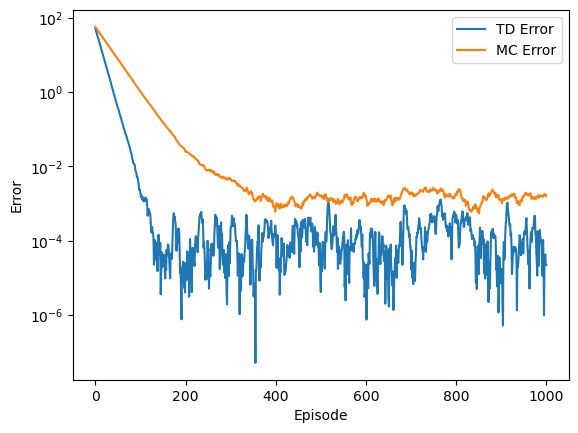

In [8]:
# Predict using model-free RL methods
alpha = 0.02  # Update ratio
n_episodes = 1000  # Episodes used to update
ep_length = 50  # Number of steps for each episode

# Monte-Carlo
print('Obtaining MC prediction...')
v_mc = np.zeros((n_episodes + 1, n_states))
for e in range(n_episodes):
  for init_state in list(np.arange(n_states)):  # For each initial state, as MC updates a single state at a time
    state = init_state
    g_mc = 0
    for k in range(ep_length):
      action = np.random.choice(np.arange(n_actions), p=pi[state, state * n_actions : (state + 1) * n_actions])
      next_state, reward = step(state, action)
      g_mc += reward * gamma ** k
      k += 1
      state = next_state
    v_mc[e + 1, init_state] = v_mc[e, init_state] + alpha * (g_mc - v_mc[e, init_state])


# Temporal Difference
print('Obtaining TD prediction...')
v_td = np.zeros((n_episodes + 1, n_states))
for e in range(n_episodes):
  state = np.random.choice(np.arange(n_states))  # TD updates all states at the same time: choose initial states randomly
  v = v_td[e, :]
  for k in range(ep_length):
    action = np.random.choice(np.arange(n_actions), p=pi[state, state * n_actions : (state + 1) * n_actions])
    next_state, reward = step(state, action)
    v[state] = v[state] + alpha * (reward + gamma * v[next_state] - v[state])  # TD update
    state = next_state
  v_td[e + 1, :] = v


values = []
values.append(['Exact'])
values[-1].extend(list(v_pi_exact))
values.append(['MC'])
values[-1].extend(list(v_mc[-1, :]))
values.append(['TD'])
values[-1].extend(list(v_td[-1, :]))
print('State value function obtained using model-free prediction:')
print(tabulate(values, tablefmt="fancy_grid", headers=['Method', 'V(x)', 'V(y)']))

plt.semilogy(np.sum(np.square(v_td - np.repeat(v_pi_exact.reshape([1, n_states]), n_episodes + 1, axis=0)), axis=1), label='TD Error')
plt.semilogy(np.sum(np.square(v_mc - np.repeat(v_pi_exact.reshape([1, n_states]), n_episodes + 1, axis=0)), axis=1), label='MC Error')
plt.legend(loc='best')
plt.xlabel('Episode')
plt.ylabel('Error')
plt.show()